# Multi Label Classification: Auto Tagging


Importing required Libraries


In [1]:
import re

import joblib
import nltk
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from nltk import WordNetLemmatizer, word_tokenize, FreqDist
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import (
    jaccard_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    hamming_loss,
)
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

Loading Dataset

In [2]:
dataset = pd.read_excel("Sample_AutoTagging_Data_Confidential.xlsx")
dataset

,SUMMARY,PRACTICE/AREA,SL/SUB-AREA
0,Climate risk and response: Physical hazards an...,Risk & Resilience|Strategy & Corporate Finance...,Sustainability - Climate & ESG Mgmt|Government...
1,New Accenture Research Finds Leaders and Emplo...,Organization,Talent|Culture & transformational change
2,"Me, my life, my wallet - The widespread and im...","Growth, Marketing & Sales",Customer experience
3,The next normal arrives: Trends that will defi...,Public And Social Sector|Risk & Resilience|Gro...,Economic development|Crisis Preparedness and R...
4,Our 2021 technology predictions for businesses...,McKinsey Technology|Organization,Tech strategy & operating model & agile|Leader...
...,...,...,...
19995,How to reshape aerospace and defence supply ch...,Aerospace & Defense|Operations|Risk & Resilience,Aerospace & Defense- Other|Manufacturing & sup...
19996,Why current challenges make a more sustainable...,Banking,Retail banking|Consumer Credit
19997,What companies should consider when making cli...,Strategy & Corporate Finance|Sustainability,CFO-Finance-Capital Markets|Sustainability inv...
19998,Post-Brexit trade: Navigating the disruption -...,Operations,Operations- Other


Dataset Information


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   SUMMARY        20000 non-null  object
 1   PRACTICE/AREA  20000 non-null  object
 2   SL/SUB-AREA    20000 non-null  object
dtypes: object(3)
memory usage: 468.9+ KB


Dataset Statistics


In [4]:
dataset.describe()

,SUMMARY,PRACTICE/AREA,SL/SUB-AREA
count,20000,20000,20000
unique,19985,5910,12637
top,Survey: US consumer sentiment during the coron...,Organization,Economic development
freq,3,1034,347


### Data-Preprocessing


In [5]:
X_train_1, X_test_1, y_train_1, y_test_1, y_train_2, y_test_2 = train_test_split(
    dataset["SUMMARY"], dataset["PRACTICE/AREA"], dataset["SL/SUB-AREA"], test_size=0.2, random_state=41
)

In [11]:
testingDataset = pd.concat([X_test_1, y_test_1, y_test_2], axis=1)
testingDataset.reset_index(drop=True, inplace=True)
testingDataset.head()

,SUMMARY,PRACTICE/AREA,SL/SUB-AREA
0,Infrastructure trends - Since the onset of the...,Public And Social Sector|Operations|Sustainabi...,Public infrastructure & cities|Capital excelle...
1,Failure is not an option: Increasing the chanc...,Sustainability|Organization,Sustainability strategy & portfolio|Decarboniz...
2,Cautiously optimistic: Chinese consumer behavi...,"Consumer Goods|Growth, Marketing & Sales|Digit...",Consumer Goods- Other|Marketing strategy- bra...
3,Three ways health insurers can reimagine partn...,Healthcare|Strategy & Corporate Finance|Operat...,Healthcare providers|M&A - S&CF|Manufacturing ...
4,Visualizing your journey - The cloud can eat a...,McKinsey Technology|Public And Social Sector|T...,Data transformation|PSSP- Other|Software|Digit...


In [12]:
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')

In [13]:
lemmatizer = WordNetLemmatizer()


def preprocess_text(document):
    # Lower case
    document = document.lower()

    # Remove punctuation and numbers
    document = re.sub(r"[^\w\s]", "", document)
    document = re.sub(r"\d+", "", document)

    # Tokenize
    tokens = word_tokenize(document)

    # Remove duplicate words
    tokens = list(set(tokens))

    # Remove stopwords, Lemmatize, and then rejoin the words
    wordsLemmatized = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in set(stopwords.words("english"))
    ]
    document = " ".join(wordsLemmatized)
    return document

In [14]:
X_train_1 = X_train_1.apply(preprocess_text)
X_test_1 = X_test_1.apply(preprocess_text)

In [15]:
X_train_1.head()

19355    past insurance driven state customer primarily...
2553     navigate costly transform creating approach ri...
4189     market forced faced sector next travel never e...
5138     rd pack period state size product examined spr...
8743     equitably smart company uninterested sector ci...
Name: SUMMARY, dtype: object

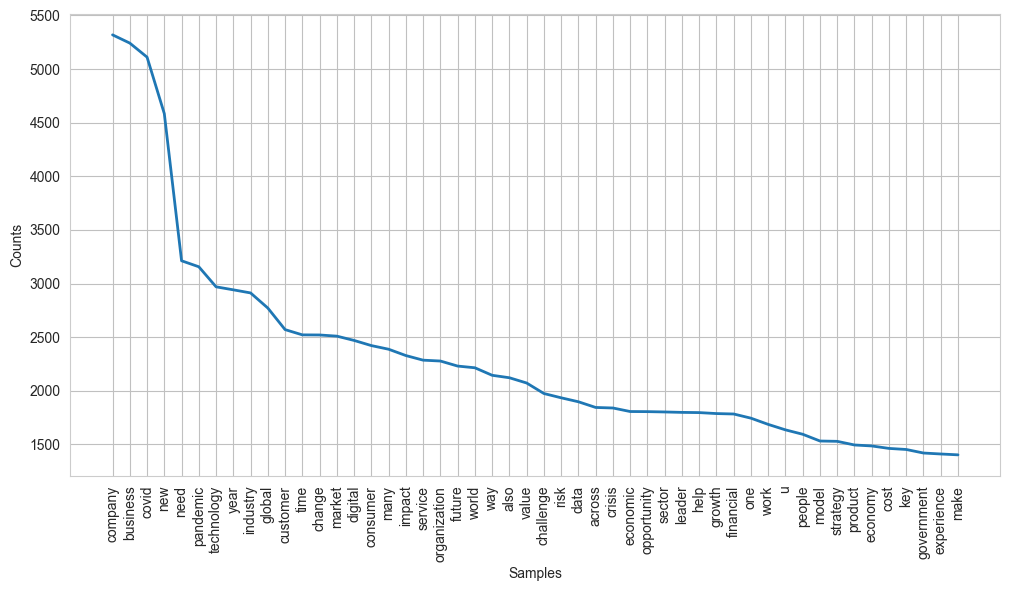

Total Words Count:  747487


In [16]:
corpus = " ".join(X_train_1)

tokens = nltk.word_tokenize(corpus)
fdist = FreqDist(tokens)

plt.figure(figsize=(12, 6))
fdist.plot(50, cumulative=False)
plt.show()
print("Total Words Count: ", len(tokens))

In [17]:
y_train_1 = y_train_1.str.split("|")
y_test_1 = y_test_1.str.split("|")

y_train_1.head()

19355                           [Healthcare, Organization]
2553     [Operations, Mckinsey Transformation, Telecom,...
4189     [Strategy & Corporate Finance, Organization, T...
5138               [Digital & Analytics (DnA), Automotive]
8743                            [Public And Social Sector]
Name: PRACTICE/AREA, dtype: object

In [18]:
mlb = MultiLabelBinarizer()
y_train_1 = mlb.fit_transform(y_train_1)
y_test_1 = mlb.fit_transform(y_test_1)
y_train_1 = pd.DataFrame(y_train_1, columns=mlb.classes_)
y_test_1 = pd.DataFrame(y_test_1, columns=mlb.classes_)
y_train_1.head()

,Advanced Electronics,Aerospace & Defense,Agriculture,Automotive,Banking,Basic Materials,Business & Consumer Services,Chemicals,Consumer Goods,Digital & Analytics (DnA),...,Private Equity,Public And Social Sector,Public and Social Sector,Retail,Risk & Resilience,Risk & resilience,Strategy & Corporate Finance,Sustainability,"Telecom, Media & Technology","Travel, Logistics & Infrastructure"
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


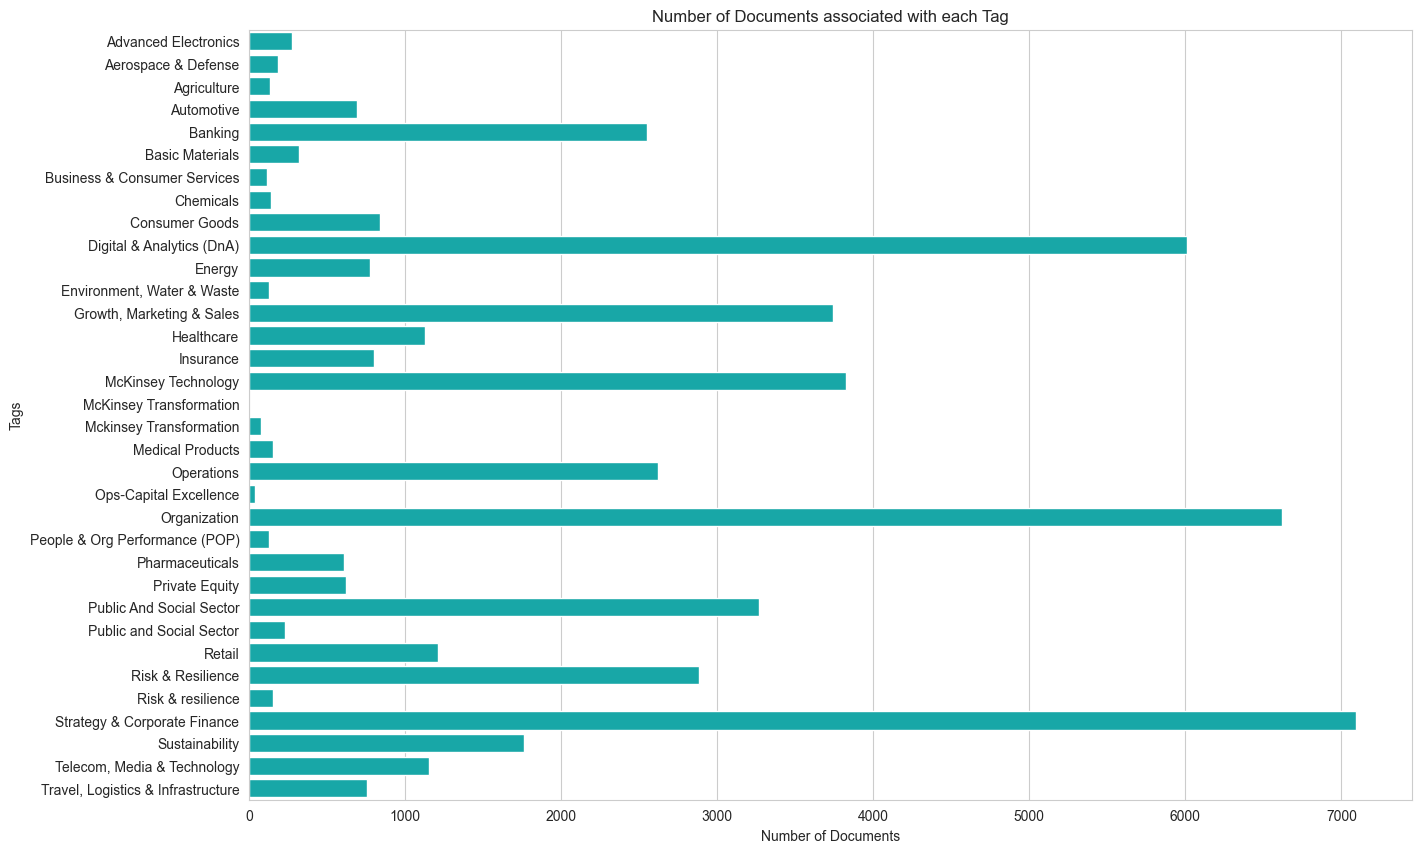

In [19]:
tag_counts = y_train_1.sum(numeric_only=True) + y_test_1.sum(numeric_only=True)

# Plot
plt.figure(figsize=(15, 10))
sns.barplot(x=tag_counts.values, y=tag_counts.index, color="c")
plt.xlabel("Number of Documents")
plt.ylabel("Tags")
plt.title("Number of Documents associated with each Tag")
plt.show()

Text Vectorization


In [43]:
tfidf = TfidfVectorizer(ngram_range=(1, 2), stop_words="english")
X_train_tfidf_1 = tfidf.fit_transform(X_train_1)
X_test_tfidf_1 = tfidf.transform(X_test_1)
X_train_tfidf_1.shape, X_test_tfidf_1.shape

((16000, 465414), (4000, 465414))

### Model Training


Random Forest Classifier


In [37]:
RFC_1 = OneVsRestClassifier(RandomForestClassifier())
rfc1 = RFC_1.fit(X_train_tfidf_1, y_train_1)

Stochastic Gradient Descent Classifier


In [38]:
SGD_1 = OneVsRestClassifier(SGDClassifier())
sgd1 = SGD_1.fit(X_train_tfidf_1, y_train_1)

Logistic Regression


In [39]:
LR_1 = OneVsRestClassifier(LogisticRegression(solver="lbfgs"))
lr1 = LR_1.fit(X_train_tfidf_1, y_train_1)

Support Vector Classifier


In [24]:
SVC_1 = OneVsRestClassifier(LinearSVC())
svc1 = SVC_1.fit(X_train_tfidf_1, y_train_1)

XGBoost Classifier


In [41]:
XGB_1 = OneVsRestClassifier(XGBClassifier())
xgb1 = XGB_1.fit(X_train_tfidf_1, y_train_1)

Ensemble Learning


In [21]:
def jaccard_scr(y_true, y_pred, average_option="samples"):
    return jaccard_score(y_true, y_pred, average=average_option)

In [30]:
models = [
    # ("RandomForest", rfc1),
    # ("SGD", sgd1),
    # ("LogisticRegression", lr1),
    ("LinearSVC", svc1),
    # ("XGBoost", xgb1),
    # ('VotingClassifier', ovr_voting_1)
]

model_comparison = {}

for model_name, model in models:
    predictions = model.predict(X_test_tfidf_1)

    accuracy = accuracy_score(y_test_1, predictions)
    precision = precision_score(
        y_test_1, predictions, average="samples", zero_division=0
    )
    recall = recall_score(y_test_1, predictions, average="samples", zero_division=0)
    f1 = f1_score(y_test_1, predictions, average="samples", zero_division=0)
    hamming_loss_value = hamming_loss(y_test_1, predictions)

    jaccard = jaccard_scr(y_test_1, predictions)

    model_comparison[model_name] = {
        "Jaccard Score": jaccard,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Hamming Loss": hamming_loss_value,
    }

    joblib.dump(model, model_name + ".joblib")

model_scores = pd.DataFrame.from_dict(model_comparison, orient="index")

model_scores

,Jaccard Score,Accuracy,Precision,Recall,F1 Score,Hamming Loss
LinearSVC,0.486793,0.1965,0.710517,0.561926,0.587296,0.0505


#### Classification


In [31]:
text = [
    "Understanding mobility’s second great inflection point - Senior partner Asutosh Padhi discusses the technological breakthroughs changing the mobility ecosystem and lays out what the shifts mean for automotive and other industries."
]
text = pd.Series(text)
text = text.apply(preprocess_text)
text_tfidf = tfidf.transform(text)
predictions = svc1.predict(text_tfidf)
predicted_labels = mlb.inverse_transform(predictions)
predicted_labels

[('Automotive', 'Insurance', 'Organization', 'Strategy & Corporate Finance')]

In [32]:
model = joblib.load("LinearSVC.joblib")

In [33]:
len(X_test_1)

4000

In [34]:
GEN_PRACTICE_AREA = []

for value in testingDataset['SUMMARY']:
    text = pd.Series(value)
    text = text.apply(preprocess_text)
    text_tfidf = tfidf.transform(text)
    predictions = model.predict(text_tfidf)
    predicted_labels = mlb.inverse_transform(predictions)
    GEN_PRACTICE_AREA.append(predicted_labels)
    print(predicted_labels)
data = {
    "GEN_PRACTICE/AREA": GEN_PRACTICE_AREA,
}
predData = pd.DataFrame(data)

[('Digital & Analytics (DnA)', 'Public And Social Sector')]
[('Sustainability',)]
[('Consumer Goods', 'Growth, Marketing & Sales', 'Retail')]
[('Healthcare',)]
[('Digital & Analytics (DnA)', 'McKinsey Technology')]
[('Operations',)]
[('Private Equity',)]
[('Banking',)]
[('Risk & Resilience', 'Strategy & Corporate Finance')]
[('Insurance',)]
[('Organization', 'Strategy & Corporate Finance')]
[('Consumer Goods', 'Growth, Marketing & Sales')]
[('Digital & Analytics (DnA)', 'McKinsey Technology')]
[()]
[('Telecom, Media & Technology',)]
[('Strategy & Corporate Finance',)]
[('Banking', 'Risk & Resilience', 'Strategy & Corporate Finance')]
[('Organization',)]
[('Insurance', 'Risk & Resilience')]
[('Digital & Analytics (DnA)', 'Growth, Marketing & Sales', 'Retail', 'Telecom, Media & Technology')]
[('Digital & Analytics (DnA)', 'Growth, Marketing & Sales')]
[('Growth, Marketing & Sales', 'Retail')]
[('Growth, Marketing & Sales',)]
[('Energy', 'Operations', 'Sustainability')]
[('Automotive', 'G

In [35]:
testingDataset

,SUMMARY,PRACTICE/AREA,SL/SUB-AREA
0,Infrastructure trends - Since the onset of the...,Public And Social Sector|Operations|Sustainabi...,Public infrastructure & cities|Capital excelle...
1,Failure is not an option: Increasing the chanc...,Sustainability|Organization,Sustainability strategy & portfolio|Decarboniz...
2,Cautiously optimistic: Chinese consumer behavi...,"Consumer Goods|Growth, Marketing & Sales|Digit...",Consumer Goods- Other|Marketing strategy- bra...
3,Three ways health insurers can reimagine partn...,Healthcare|Strategy & Corporate Finance|Operat...,Healthcare providers|M&A - S&CF|Manufacturing ...
4,Visualizing your journey - The cloud can eat a...,McKinsey Technology|Public And Social Sector|T...,Data transformation|PSSP- Other|Software|Digit...
...,...,...,...
3995,Accelerating smart manufacturing - As COVID-19...,Operations|Strategy & Corporate Finance|McKins...,Manufacturing & supply chain|M&A - S&CF|McKins...
3996,"Workforce, people and communications - First a...",Organization|Strategy & Corporate Finance,Talent|Corporate & Portfolio Strategy
3997,Five utility trends to watch in 2022 as energy...,Energy|Strategy & Corporate Finance|Operations...,Power & natural gas retailing|M&A - S&CF|Manuf...
3998,What the energy transition means to providers ...,Energy|Business & Consumer Services|Sustainabi...,Oil & Gas|Legal services|Green business building


In [36]:
predData

,GEN_PRACTICE/AREA
0,"[(Digital & Analytics (DnA), Public And Social..."
1,"[(Sustainability,)]"
2,"[(Consumer Goods, Growth, Marketing & Sales, R..."
3,"[(Healthcare,)]"
4,"[(Digital & Analytics (DnA), McKinsey Technolo..."
...,...
3995,"[(Digital & Analytics (DnA), McKinsey Technolo..."
3996,"[(Organization, Strategy & Corporate Finance)]"
3997,"[(Energy, Strategy & Corporate Finance, Sustai..."
3998,"[(Energy, Organization, Sustainability)]"


In [37]:
newDataset2 = pd.concat([testingDataset, predData], axis=1)
# newDataset2.head()
newDataset2.to_excel("generated_tags.xlsx", index=False)
x = pd.read_excel('generated_tags.xlsx')
x.head()

,SUMMARY,PRACTICE/AREA,SL/SUB-AREA,GEN_PRACTICE/AREA
0,Infrastructure trends - Since the onset of the...,Public And Social Sector|Operations|Sustainabi...,Public infrastructure & cities|Capital excelle...,"[('Digital & Analytics (DnA)', 'Public And Soc..."
1,Failure is not an option: Increasing the chanc...,Sustainability|Organization,Sustainability strategy & portfolio|Decarboniz...,"[('Sustainability',)]"
2,Cautiously optimistic: Chinese consumer behavi...,"Consumer Goods|Growth, Marketing & Sales|Digit...",Consumer Goods- Other|Marketing strategy- bra...,"[('Consumer Goods', 'Growth, Marketing & Sales..."
3,Three ways health insurers can reimagine partn...,Healthcare|Strategy & Corporate Finance|Operat...,Healthcare providers|M&A - S&CF|Manufacturing ...,"[('Healthcare',)]"
4,Visualizing your journey - The cloud can eat a...,McKinsey Technology|Public And Social Sector|T...,Data transformation|PSSP- Other|Software|Digit...,"[('Digital & Analytics (DnA)', 'McKinsey Techn..."


In [77]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

num_features = X_train_tfidf_1.shape[1]
num_classes = y_train_1.shape[1]

model = Sequential()
model.add(Input(shape=(num_features,)))
model.add(Dense(256, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(num_classes, activation="sigmoid"))

In [78]:
# Compile the model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [79]:
# Train the model
history = model.fit(
    X_train_tfidf_1, y_train_1, epochs=10, batch_size=32, validation_split=0.2
)

Epoch 1/10


C:\Users\Rituraj.Raman\Desktop\AIRA Project\AutoTagger\venv\Lib\site-packages\tensorflow\python\framework\indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 129746176 elements. This may consume a large amount of memory.
  warnings.warn(


450/450 ━━━━━━━━━━━━━━━━━━━━ 387s 856ms/step - accuracy: 0.0814 - loss: 0.3192 - val_accuracy: 0.2500 - val_loss: 0.1875
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 381s 846ms/step - accuracy: 0.3482 - loss: 0.1426 - val_accuracy: 0.3650 - val_loss: 0.1634
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 383s 850ms/step - accuracy: 0.4502 - loss: 0.0574 - val_accuracy: 0.3944 - val_loss: 0.1898
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 377s 837ms/step - accuracy: 0.4796 - loss: 0.0250 - val_accuracy: 0.3981 - val_loss: 0.2497
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 380s 844ms/step - accuracy: 0.5087 - loss: 0.0129 - val_accuracy: 0.3606 - val_loss: 0.3025
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 378s 840ms/step - accuracy: 0.5079 - loss: 0.0080 - val_accuracy: 0.3706 - val_loss: 0.3140
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 388s 861ms/step - accuracy: 0.5113 - loss: 0.0046 - val_accuracy: 0.3594 - val_loss: 0.3629
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 378s 839ms/step - accuracy: 0.5082 - loss: 0.00

In [80]:
# Save the Model
model.save("nnmodel.keras")

In [74]:
# Predicting the tags
score = model.evaluate(X_train_tfidf_1, y_train_1, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])
y_pred = model.predict(X_test_tfidf_1)
y_pred = y_pred.argmax(axis=1)

Test loss: 0.0723656564950943
Test accuracy: 0.5046111345291138
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


array([25, 31, 12, ..., 21, 30,  4], dtype=int64)

In [75]:
predictions = model.predict(X_test_tfidf_1)
threshold = 0.4
binary_predictions = (predictions > threshold).astype(int)
binary_predictions

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [76]:
predicted_labels = mlb.inverse_transform(binary_predictions)
predicted_labels

[(),
 ('Sustainability',),
 ('Growth, Marketing & Sales', 'Retail'),
 (),
 ('Digital & Analytics (DnA)',),
 ('Operations',),
 (),
 (),
 ('Strategy & Corporate Finance',),
 (),
 ('Organization',),
 (),
 ('Digital & Analytics (DnA)', 'McKinsey Technology'),
 (),
 (),
 (),
 ('Risk & Resilience',),
 ('Organization',),
 ('Risk & Resilience',),
 ('Growth, Marketing & Sales',),
 ('Growth, Marketing & Sales',),
 ('Growth, Marketing & Sales', 'Retail'),
 (),
 (),
 ('Automotive',),
 ('Public And Social Sector',),
 (),
 (),
 ('Banking',),
 (),
 ('Growth, Marketing & Sales', 'Telecom, Media & Technology'),
 ('Organization',),
 (),
 (),
 ('Digital & Analytics (DnA)',),
 (),
 ('Strategy & Corporate Finance',),
 (),
 (),
 ('Banking',),
 ('Growth, Marketing & Sales',),
 (),
 ('Digital & Analytics (DnA)',),
 (),
 ('Digital & Analytics (DnA)',),
 (),
 (),
 ('Organization', 'Public And Social Sector'),
 ('Growth, Marketing & Sales',),
 ('Growth, Marketing & Sales', 'Retail'),
 (),
 (),
 (),
 ('Organizati

### 2nd Label Prediction


In [38]:
X_train_1.head()

19355    past insurance driven state customer primarily...
2553     navigate costly transform creating approach ri...
4189     market forced faced sector next travel never e...
5138     rd pack period state size product examined spr...
8743     equitably smart company uninterested sector ci...
Name: SUMMARY, dtype: object

In [39]:
y_train_2 = y_train_2.str.split("|")
y_test_2 = y_test_2.str.split("|")

y_train_2.head()

19355                      [Healthcare payers, Leadership]
2553     [Manufacturing & supply chain, MT transformati...
4189     [CFO-Finance-Capital Markets, Org design & op ...
5138         [DnA powered-other topics, Automotive- Other]
8743                                         [PSSP- Other]
Name: SL/SUB-AREA, dtype: object

In [40]:
mlb2 = MultiLabelBinarizer()
y_train_2 = mlb2.fit_transform(y_train_2)
y_train_2 = pd.DataFrame(y_train_2, columns=mlb2.classes_)
y_test_2 = mlb2.fit_transform(y_test_2)
y_test_2 = pd.DataFrame(y_test_2, columns=mlb2.classes_)
y_train_2.head()

,Accounting services,Advanced Electronics- Other,Advanced materials,Aerospace & Defense- Other,Aerospace aftermarket & services,Aerospace equipment & products,Aftermarket & services,Agricultural inputs,Agricultural produce trading & processing,Agriculture input distribution & service,...,"Travel, Logistics & Infrastructure- Other",Underwriting,Venture Capital,Venture capital,Water,Wealth & asset management,Wealth and asset management,consumer electronics,food,talent
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


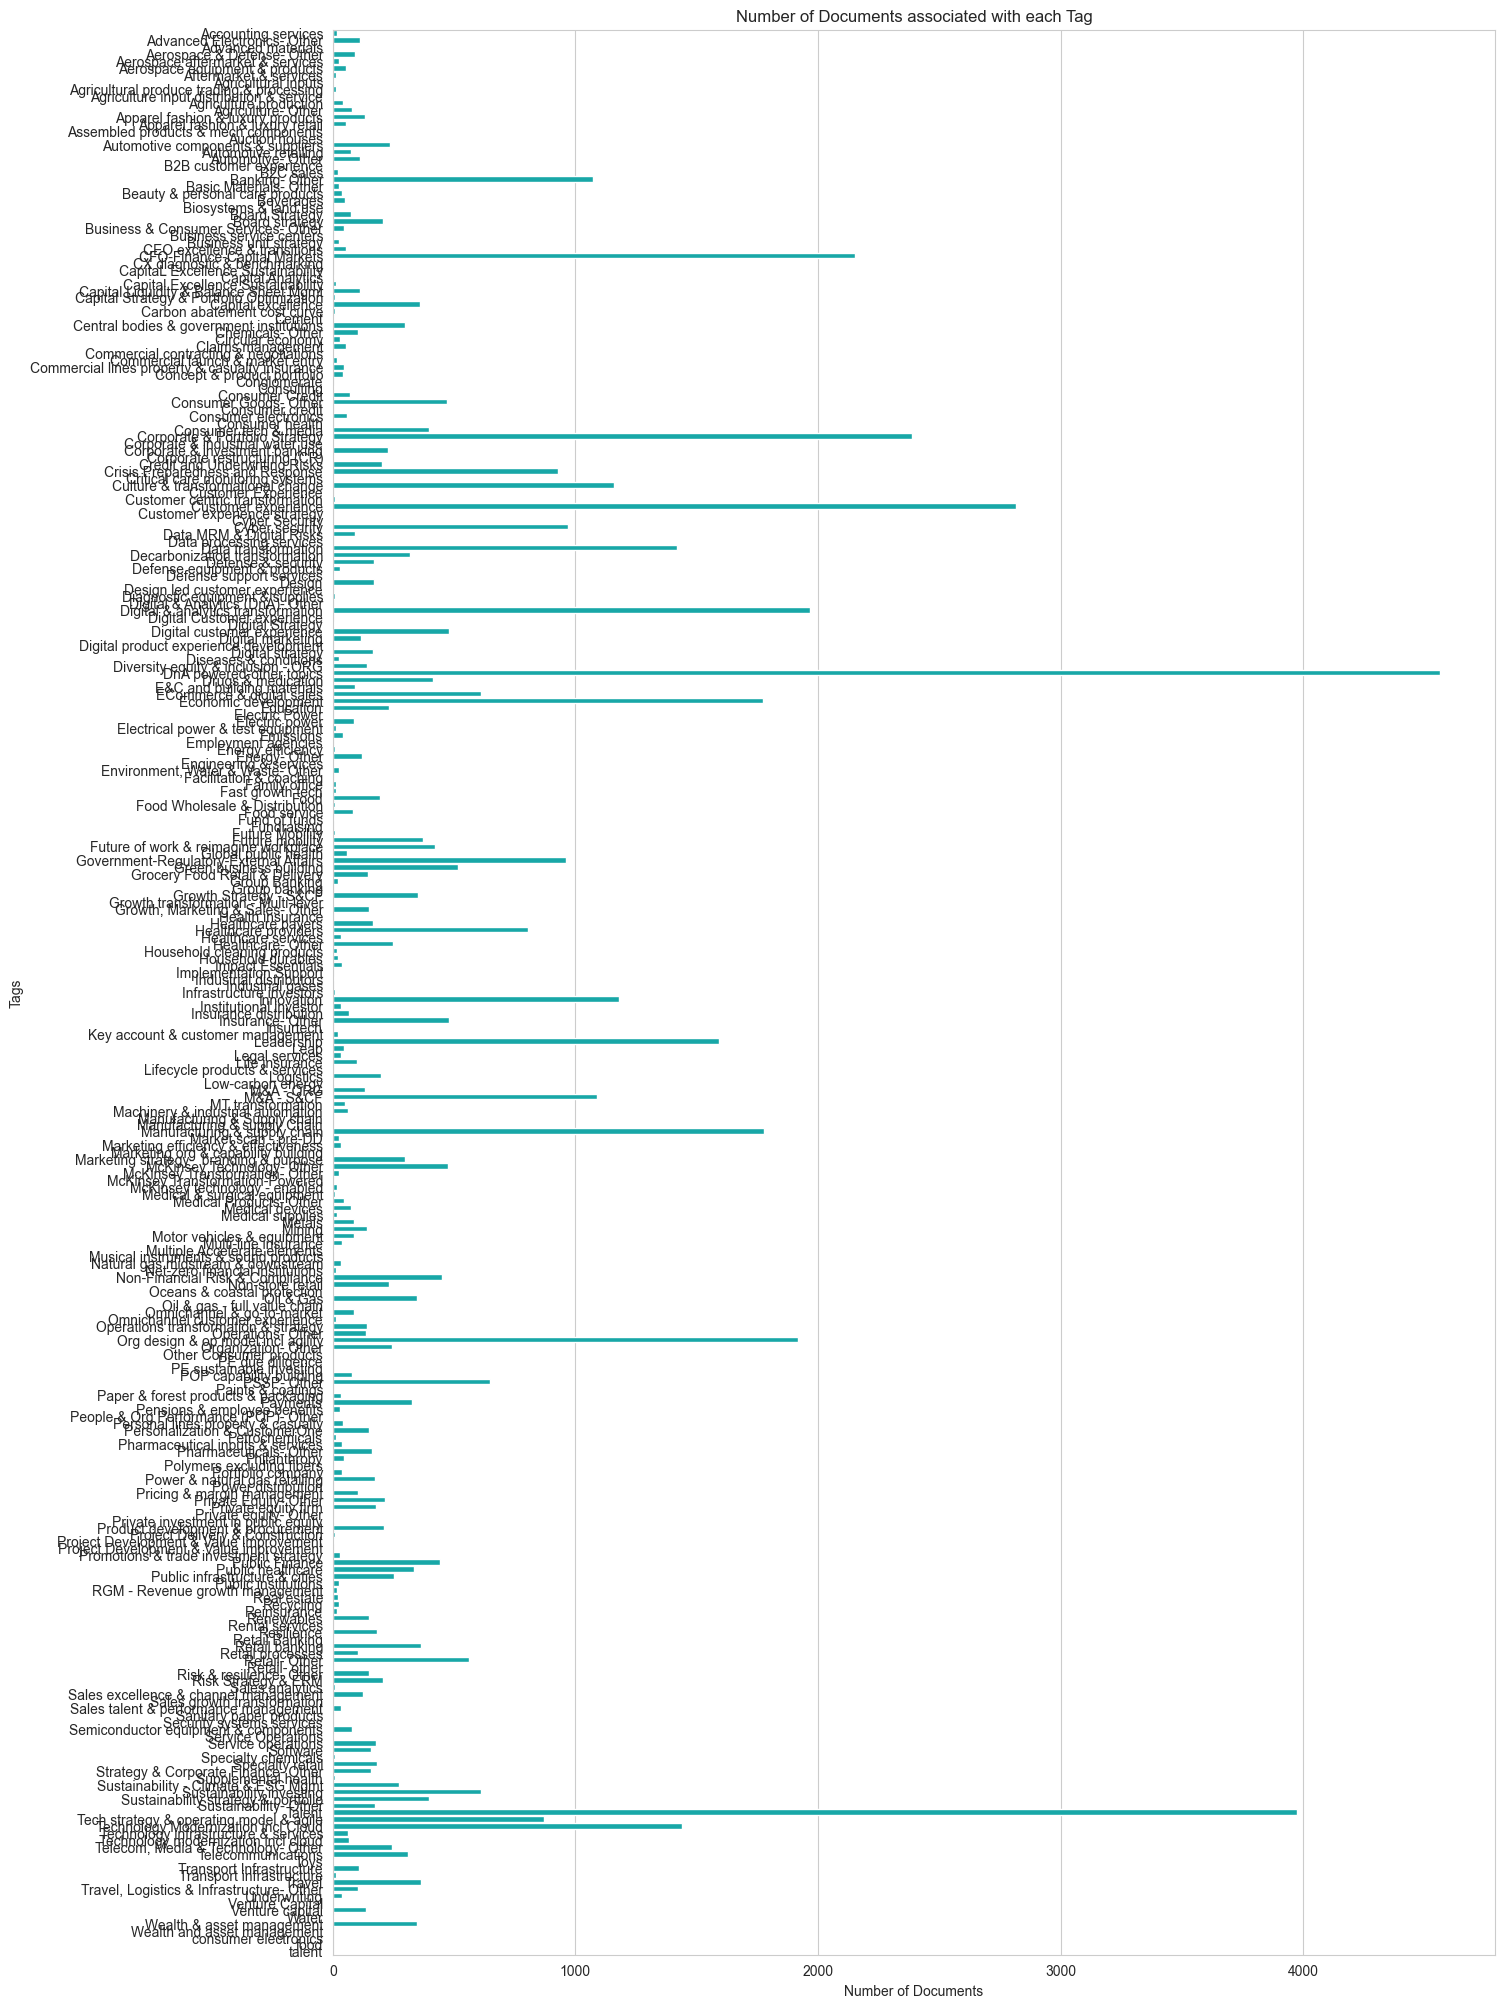

In [41]:
tag_counts = y_train_2.sum(numeric_only=True) + y_test_2.sum(numeric_only=True)

# Plot
plt.figure(figsize=(15, 25))
sns.barplot(x=tag_counts.values, y=tag_counts.index, color="c")
plt.xlabel("Number of Documents")
plt.ylabel("Tags")
plt.title("Number of Documents associated with each Tag")
plt.show()

Text Vectorization


### Model Training

Random Forest Classifier

In [ ]:
RFC_2 = OneVsRestClassifier(RandomForestClassifier())
rfc2 = RFC_2.fit(X_train_tfidf_1, y_train_2)

Stochastic Gradient Descent Classifier


In [ ]:
SGD_2 = OneVsRestClassifier(SGDClassifier())
sgd2 = SGD_2.fit(X_train_tfidf_1, y_train_2)

Logistic Regression


In [ ]:
LR_2 = OneVsRestClassifier(LogisticRegression(solver="lbfgs"))
lr2 = LR_2.fit(X_train_tfidf_1, y_train_2)

Support Vector Classifier


In [44]:
SVC_2 = OneVsRestClassifier(LinearSVC())
svc2 = SVC_2.fit(X_train_tfidf_1, y_train_2)

XGBoost Classifier


In [ ]:
XGB_2 = OneVsRestClassifier(XGBClassifier())
xgb2 = XGB_2.fit(X_train_tfidf_1, y_train_2)

In [46]:
models = [
    # ("RandomForest", rfc2),
    # ("SGD", sgd2),
    # ("LogisticRegression", lr2),
    ("LinearSVC", svc2),
    # ("XGBoost", xgb2),
]

model_comparison = {}

for model_name, model in models:
    predictions = model.predict(X_test_tfidf_1)

    accuracy = accuracy_score(y_test_2, predictions)
    precision = precision_score(
        y_test_2, predictions, average="samples", zero_division=0
    )
    recall = recall_score(y_test_2, predictions, average="samples", zero_division=0)
    f1 = f1_score(y_test_2, predictions, average="samples", zero_division=0)
    hamming_loss_value = hamming_loss(y_test_2, predictions)

    jaccard = jaccard_scr(y_test_2, predictions)

    model_comparison[model_name] = {
        "Jaccard Score": jaccard,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Hamming Loss": hamming_loss_value,
    }

    joblib.dump(model, model_name + "2.joblib")

model_scores = pd.DataFrame.from_dict(model_comparison, orient="index")

model_scores

ValueError: inconsistent shapes

#### Classification


In [ ]:
text = [
    "Understanding mobility’s second great inflection point - Senior partner Asutosh Padhi discusses the technological breakthroughs changing the mobility ecosystem and lays out what the shifts mean for automotive and other industries."
]
text = pd.Series(text)
text = text.apply(preprocess_text)
text_tfidf = tfidf.transform(text)
predictions = svc2.predict(text_tfidf)

In [49]:
predictions

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [50]:
predicted_labels = mlb2.inverse_transform(predictions)
predicted_labels

ValueError: Expected indicator for 232 classes, but got 273

In [ ]:
model = joblib.load("LinearSVC2.joblib")

In [ ]:
len(X_test_1)

In [ ]:
GEN_SL_SUBAREA = []

for value in testingDataset['SUMMARY']:
    text = pd.Series(value)
    text = text.apply(preprocess_text)
    text_tfidf = tfidf.transform(text)
    predictions = model.predict(text_tfidf)
    predicted_labels = mlb2.inverse_transform(predictions)
    GEN_PRACTICE_AREA.append(predicted_labels)
    print(predicted_labels)
data = {
    "GEN_SL/SUB-AREA": GEN_SL_SUBAREA,
}
predData = pd.DataFrame(data)

In [ ]:
newDataset2

In [ ]:
predData

In [22]:
newDataset3 = pd.concat([newDataset2, X_test_2, predData], axis=1)
newDataset2.head()
# newDataset3.to_excel("generated_tags.xlsx", index=False)
# x = pd.read_excel('generated_tags.xlsx')
# x.head()

NameError: name 'newDataset2' is not defined